In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, cdist
from scipy.spatial.distance import squareform
# from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [3]:
from utils_cluster import genNormalizedX
from utils_plot import clsInspection

In [4]:
from fastdtw import fastdtw as fastdtw

In [5]:
# Replace 'your_file.csv' with the actual path to your CSV file
file_path = 'Synthetic_crash_scenarios.csv'
# file_path = '/content/drive/MyDrive/Colab Notebooks/Thesis Crash Generation/New dataset/Synthetic_crash_scenarios.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Load the Data

In [6]:
V_l = np.zeros((5000,97))
V_f = np.zeros((5000,97))
D = np.zeros((5000,97))
Weight = np.zeros(5000)
for i in range(1,5001):
    v_l_i = df[df["id"]==i].iloc[-98:-1, 3].to_numpy()
    v_f_i = df[df["id"]==i].iloc[-98:-1, 2].to_numpy()
    d_i = df[df["id"]==i].iloc[-98:-1, 4].to_numpy() - df[df["id"]==i].iloc[-2, 4]
    weight_i = df[df["id"]==i].iloc[0, 6]
    V_l[i-1,:], V_f[i-1,:], D[i-1,:] = v_l_i, v_f_i, d_i
    Weight[i-1] = weight_i

V_l_raw = copy.deepcopy(V_l)
V_f_raw = copy.deepcopy(V_f)
D_raw = copy.deepcopy(D)
Weight_raw = copy.deepcopy(Weight)

In [7]:
V_l = copy.deepcopy(V_l_raw)
V_f = copy.deepcopy(V_f_raw)
D = copy.deepcopy(D_raw)
A_l = np.gradient(V_l, axis=1)/0.05
A_f = np.gradient(V_f, axis=1)/0.05
Weight = copy.deepcopy(Weight_raw)

# X = genNormalizedX(V_l,V_f,D,A_l,A_f)
X = genNormalizedX(V_l,V_f,D)

# Clustering

In [8]:
def hc_dm(X, alg="euclidean"):
    '''
    Calculate the distance matrix for H Clustering
    '''
    if alg == 'euclidean':
        dist_matrix = pdist(X)
    elif alg == 'dtw':
        dist_matrix = pdist(X, lambda u, v: fastdtw(u, v)[0])
    else:
        raise ValueError("Invalid algorithm. Please choose 'euclidean' or 'dtw'.")
    return dist_matrix

def hc_fcluster(dist_matrix, method='single', n_cls=16, figsize=(10, 8)):
    '''
    inputs: distance matrix
    output: cluster label
    '''
    ## form linkage
    Z = linkage(dist_matrix, method=method)
    ## assign labels
    y = fcluster(Z, t=n_cls, criterion='maxclust')
    ## plot dendrogram
    if figsize is not None:
        plt.figure(figsize=figsize)
        dendrogram(Z, truncate_mode='lastp', p=n_cls)
        plt.show()
    return y

In [9]:
def hc_secondary(dist_matrix,y,y_target,n_target,filter_threshold=None,method='single',figsize=(4,3.2)):
    '''
    dist_matrix: raw dm
    y: cluster labels
    y_target: the cluster label that we want to do secondary clustering
    n_target: number of clusters for secondary clustering
    '''
    ## extract distance matrix for
    dm_squareform = squareform(dist_matrix)
    dm_sec = dm_squareform[y==y_target][:,y==y_target]
    dm_sec = squareform(dm_sec)

    y_updated = np.copy(y)
    if figsize is None:
        y_sec = hc_fcluster(dm_sec, method=method, n_cls=n_target, figsize=None)
    else:
        y_sec = hc_fcluster(dm_sec, method=method, n_cls=n_target, figsize=figsize)
    if filter_threshold is not None:
        y_sec = filterOutlier(y_sec,threshold=filter_threshold)
    y_updated[y_updated==y_target] += y_sec
    return y_updated

In [10]:
def filterOutlier(y,threshold=2):
    '''
    threshold: number of minimum samples in a cluster
    '''
    y_updated = np.copy(y)
    labels, numbers = np.unique(y,return_counts=True)
    for i, label in enumerate(labels):
        if numbers[i]<threshold:
            y_updated[y==label] = 0
    return y_updated

In [11]:
def mergeOutlierToOther(dist_matrix,y,y_target):
    dm_sqr = squareform(dist_matrix)
    dm_sqr_target = dm_sqr[y==y_target]
    labels = np.unique(y)
    min_dist = np.zeros((dm_sqr_target.shape[0],labels.shape[0]))
    for i_label, label in enumerate(labels):
        min_dist[:,i_label] = np.min(dm_sqr_target[:,y==label],axis=1)
    y[y==y_target] = labels[labels!=y_target][np.argmin(min_dist[:,labels!=y_target],axis=1)]

First Clustering

In [12]:
# dist_matrix = pdist(X[:,:,1], lambda u, v: fastdtw(u, v)[0])
# np.save('hc_dm.npy', dist_matrix)

In [13]:
dist_matrix = np.load('hc_dm.npy')

In [14]:
n_clusters = 12
y = hc_fcluster(dist_matrix, method='single', n_cls=n_clusters, figsize=None)
y = filterOutlier(y)

Second Clustering

In [15]:
y_updated = y*100
## Cluster 2
y_updated = hc_secondary(dist_matrix,y_updated,y_target=2*100,n_target=2,filter_threshold=None,method='single',figsize=None)
## Cluster 3
y_updated = hc_secondary(dist_matrix,y_updated,y_target=3*100,n_target=38,filter_threshold=None,method='single',figsize=None)
y_updated = filterOutlier(y_updated,threshold=10)
## Cluster 5
y_updated = hc_secondary(dist_matrix,y_updated,y_target=5*100,n_target=2,filter_threshold=None,method='single',figsize=None)
## Cluster 6
y_updated = hc_secondary(dist_matrix,y_updated,y_target=6*100,n_target=70,filter_threshold=None,method='single',figsize=None)
y_updated = filterOutlier(y_updated,threshold=10)
## Cluster 6.9
y_updated = y_updated*100
y_updated = hc_secondary(dist_matrix,y_updated,y_target=609*100,n_target=4,filter_threshold=None,method='complete',figsize=None)
## Cluster 6.18
y_updated = hc_secondary(dist_matrix,y_updated,y_target=618*100,n_target=5,filter_threshold=None,method='complete',figsize=None)
## Cluster 6.38
y_updated = hc_secondary(dist_matrix,y_updated,y_target=638*100,n_target=3,filter_threshold=None,method='complete',figsize=None)

mergeOutlierToOther(dist_matrix,y_updated,y_target=0)

In [16]:
np.unique(y_updated,return_counts=True)

(array([10000, 20100, 20200, 31800, 31900, 32100, 40000, 50100, 50200,
        60901, 60902, 60903, 60904, 61801, 61802, 61803, 61804, 61805,
        63801, 63802, 63803]),
 array([ 873,   52,  242,   69,  244,   94,   11,   46,  110,   41,  319,
          71,  108,   45,   72,   75,   18,   27, 1055, 1054,  374],
       dtype=int64))

In [17]:
# array([ 142,  873,   52,  242,   44,  237,   77,   11,   46,  108,   30,
#          318,  71,  105,   28,   69,   66,   15,   26, 1039, 1043,  358],
# array([       873,   52,  242,   69,  244,   94,   11,   46,  110,   41, 
#          319,  71,  108,   45,   72,   75,   18,   27, 1055, 1054,  374],

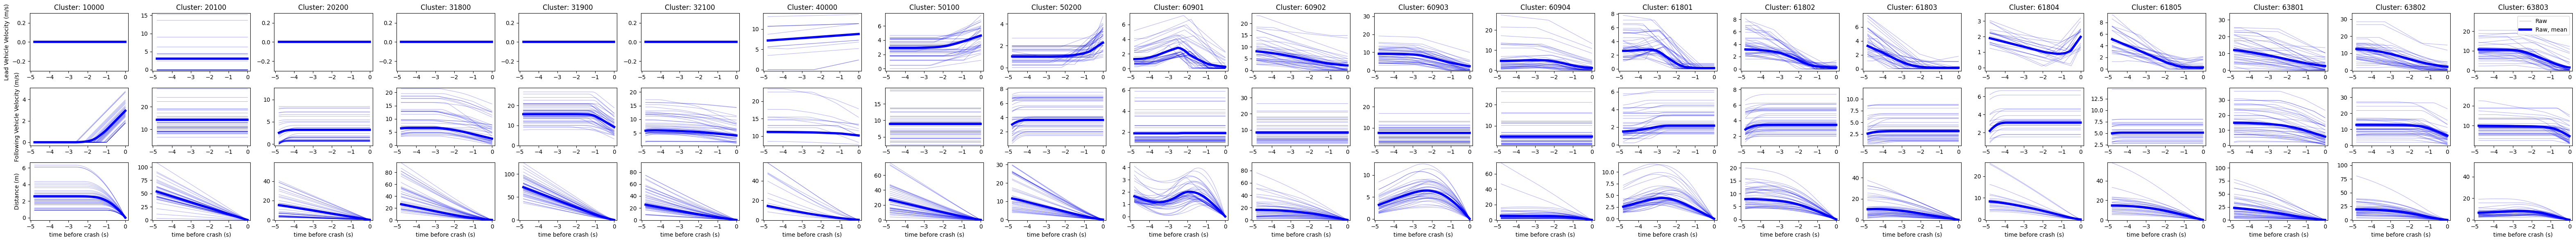

In [18]:
clsInspection(
    X,
    y_updated,
    Weight,
    dimen=3,
#     cluster_selection = list(np.unique(y_updated)[1:]),
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

In [51]:
def split_based_on_labels(y,weights,split_size = 0.5):
    idxes_splited = []
    labels = np.unique(y)
    for label in labels:
        i = 0
        # print(label)
        idxes_cls = np.arange(y.shape[0])[y==label]
        while True:
            i += 1
            if i>10000:
                raise ValueError("couldn't split")
            np.random.shuffle(idxes_cls)
            weights_cls = weights[idxes_cls]
            weights_cls_sum = np.sum(weights_cls)
            weights_cls_cumsum = np.cumsum(weights_cls)
            weights_cls_cumsum -= split_size*weights_cls_sum
            
            # Initialize variables to store the closest value and its index
            closest_index = 0
            closest_value = weights_cls_cumsum[0]
            # Iterate through the array to find the closest value to 0
            for i in range(1, len(weights_cls_cumsum)):
                if abs(weights_cls_cumsum[i]) < abs(closest_value):
                    closest_value = weights_cls_cumsum[i]
                    closest_index = i
                    
            ## if the weight value is within a threshold, store
            if abs(closest_value)<=1:
                idxes_cls_splited = idxes_cls[:closest_index+1]
                break
            elif label == 40000:
                if abs(closest_value)<=3:
                    idxes_cls_splited = idxes_cls[:closest_index+1]
                    print(idxes_cls_splited, idxes_cls[closest_index+1:])
                    break
#                 else:
#                     print(weights_cls_cumsum)
                
        idxes_splited.append(idxes_cls_splited)
        
    idxes_splited = np.array([item for sublist in idxes_splited for item in sublist])
    return idxes_splited

In [52]:
Idx_train = split_based_on_labels(y_updated, Weight, split_size = 0.5)
Idx_valtest = np.array([element for element in np.arange(y_updated.shape[0]) if element not in Idx_train])

[1558  417] [2313  716  686 1396 1230 1837  764 1306  518]


In [53]:
Idx_val = split_based_on_labels(y_updated[Idx_valtest], Weight[Idx_valtest], split_size = 0.5)
Idx_test = np.array([element for element in np.arange(Idx_valtest.shape[0]) if element not in Idx_val])
Idx_val = Idx_valtest[Idx_val]
Idx_test = Idx_valtest[Idx_test]

[ 256  383 1140  649  608] [913 343 682 359]


# Distribution Check

In [58]:
def mean_error_trainvaltest(kinematic, weight, Idx_train, Idx_val, Idx_test):
    mean_train = np.average(kinematic[Idx_train],axis = 0, weights=weight[Idx_train])
    mean_val = np.average(kinematic[Idx_val],axis = 0, weights=weight[Idx_val])
    mean_test = np.average(kinematic[Idx_test],axis = 0, weights=weight[Idx_test])

    error1 = np.linalg.norm(mean_train - mean_val)
    error2 = np.linalg.norm(mean_train - mean_test)
    error3 = np.linalg.norm(mean_val - mean_test)
    return error1, error2, error3, mean_train, mean_val, mean_test

def distribution_check(V_l, V_f, D, weight, Idx_train, Idx_val, Idx_test):
    Kine = [V_l[:,-1], V_f[:,-1] - V_l[:,-1], (V_l[:,-1] - V_l[:,-2])/0.05, (V_f[:,-1] - V_f[:,-2])/0.05]
    for kine in Kine:
        ks_stat, ks_p = weighted_ks_2samp(kine[Idx_train],kine[Idx_val],weight[Idx_train],weight[Idx_val])
        if ks_p < 0.1:
            return False
        ks_stat, ks_p = weighted_ks_2samp(kine[Idx_train],kine[Idx_test],weight[Idx_train],weight[Idx_test])
        if ks_p < 0.1:
            return False
        ks_stat, ks_p = weighted_ks_2samp(kine[Idx_val],kine[Idx_test],weight[Idx_val],weight[Idx_test])
        if ks_p < 0.1:
            return False
  
    Kine = [V_l, V_f, D]
    for kine in Kine:
        error1, error2, error3, _, _, _ = mean_error_trainvaltest(kine, weight, Idx_train, Idx_val, Idx_test)
        if error1>4 or error2>4 or error3>4:
            return False
      
    return True

In [54]:
# np.intersect1d(np.where(y_updated==40000)[0], Idx_valtest)

In [ ]:
Idx_train = split_based_on_labels(y_updated, Weight, split_size = 0.5)
Idx_valtest = np.array([element for element in np.arange(y_updated.shape[0]) if element not in Idx_train])

Idx_val = split_based_on_labels(y_updated[Idx_valtest], Weight[Idx_valtest], split_size = 0.5)
Idx_test = np.array([element for element in np.arange(Idx_valtest.shape[0]) if element not in Idx_val])
Idx_val = Idx_valtest[Idx_val]
Idx_test = Idx_valtest[Idx_test]

In [57]:
distribution_check(V_l, V_f, D, Weight, Idx_train, Idx_val, Idx_test)

NameError: name 'weighted_ks_2samp' is not defined

# Cluster Visual Check

First Clustering

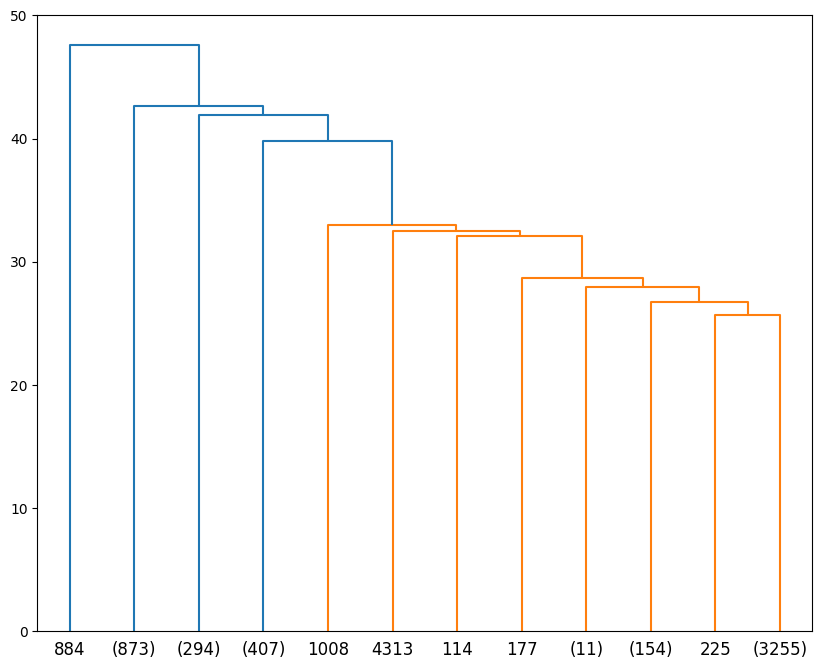

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([   6,  873,  294,  407,   11,  154, 3255], dtype=int64))

In [22]:
n_clusters = 12
# y = hc_fcluster(dist_matrix, method='single', n_cls=n_clusters, figsize=None)
y = hc_fcluster(dist_matrix, method='single', n_cls=n_clusters, figsize=(10,8))
y = filterOutlier(y)
np.unique(y,return_counts=True)

In [23]:
# mergeOutlierToOther(dist_matrix,y,y_target=0)
# np.unique(y,return_counts=True)

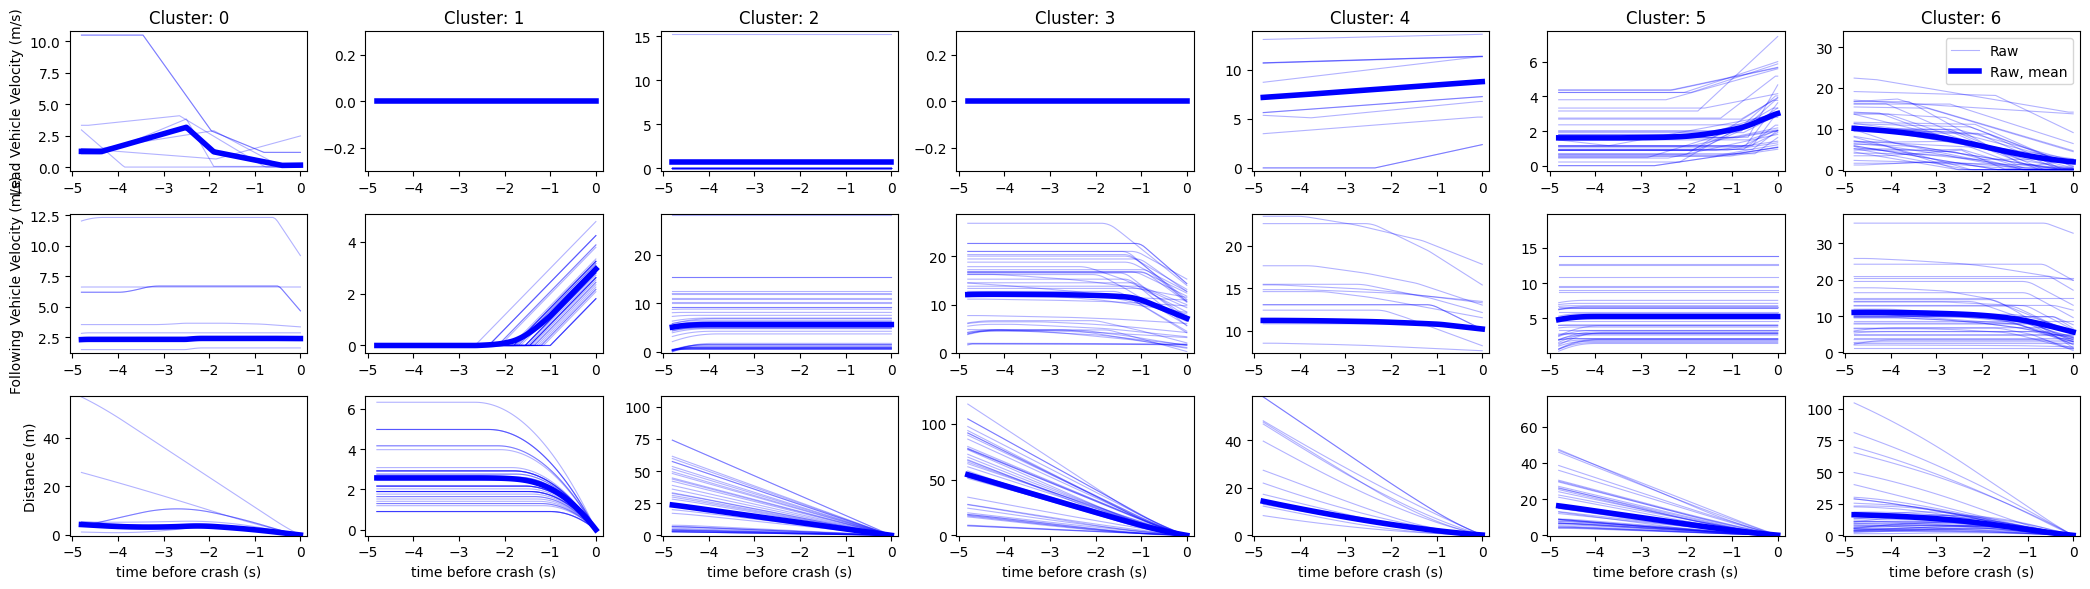

In [24]:
clsInspection(
    X,
    y,
    Weight,
    dimen=3,
#     cluster_selection = list(np.unique(y)[1:]),
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

Second Clustering y=2

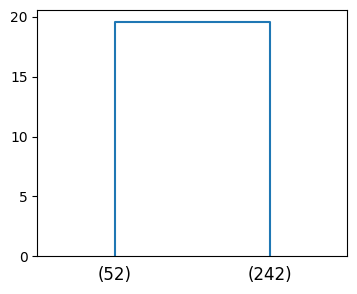

In [25]:
y_target = 2
dm_squareform = squareform(dist_matrix)
dm_sec = dm_squareform[y==y_target][:,y==y_target]
dm_sec = squareform(dm_sec)
y_sec = hc_fcluster(dm_sec, method='single', n_cls=2, figsize=(4, 3.2))
# y_sec_filter = filterOutlier(y_sec,threshold=10)

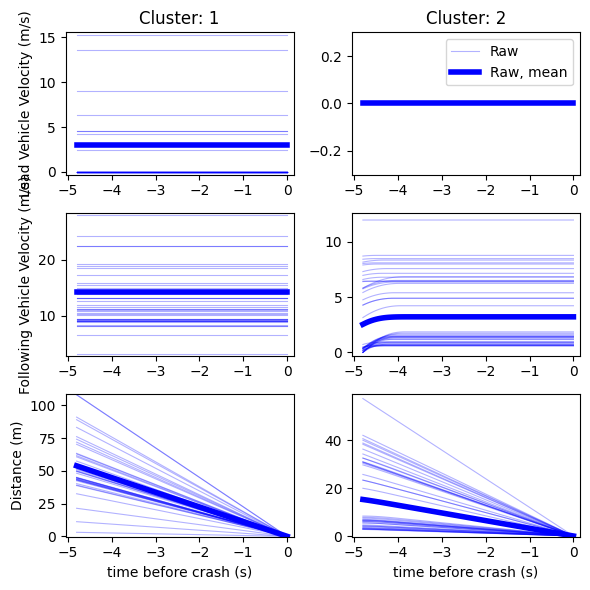

In [26]:
clsInspection(
    X[y==y_target],
    y_sec,
    Weight[y==y_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

Second Clustering y=3

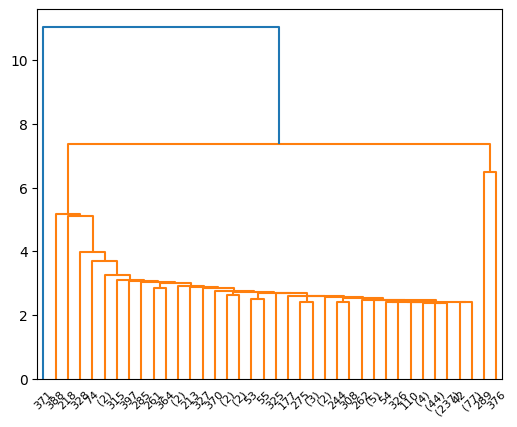

(array([ 0, 18, 19, 21], dtype=int32),
 array([ 49,  44, 237,  77], dtype=int64))

In [27]:
y_target = 3
dm_squareform = squareform(dist_matrix)
dm_sec = dm_squareform[y==y_target][:,y==y_target]
dm_sec = squareform(dm_sec)
# y_sec = hc_fcluster(dm_sec, method='complete', n_cls=3, figsize=(4, 3.2))
y_sec = hc_fcluster(dm_sec, method='single', n_cls=38, figsize=(6,4.8))
y_sec = filterOutlier(y_sec,threshold=10)
np.unique(y_sec,return_counts=True)

In [28]:
# mergeOutlierToOther(dm_sec,y_sec,y_target=1)
# np.unique(y_sec,return_counts=True)

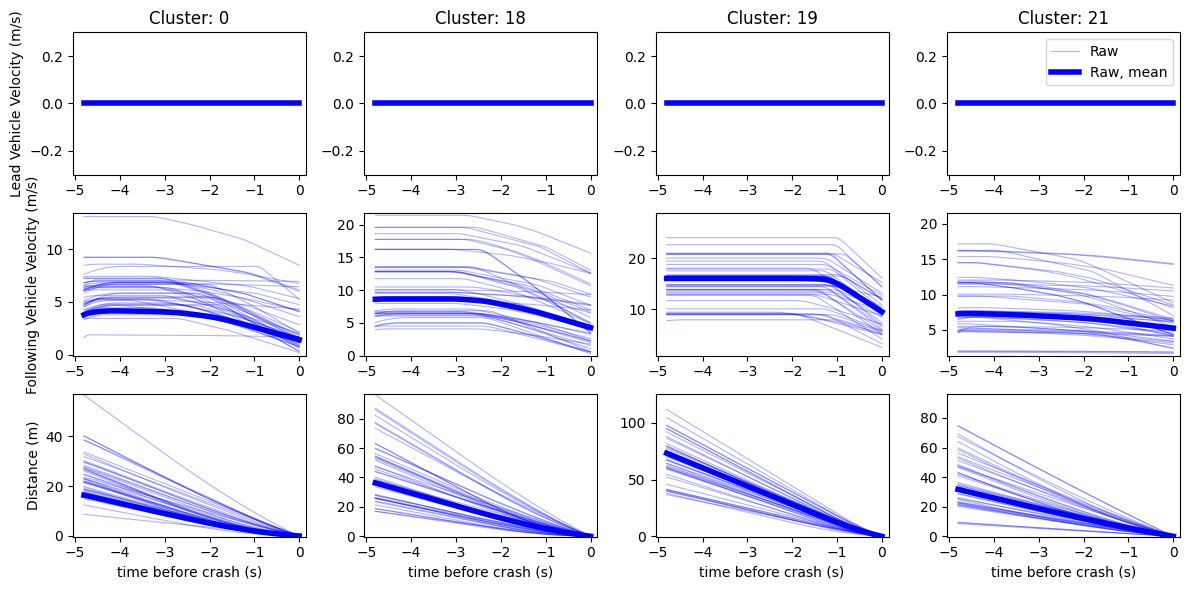

In [29]:
# y_target = 3
# dm_squareform = squareform(dist_matrix)
# dm_sec = dm_squareform[y==y_target][:,y==y_target]
# dm_sec = squareform(dm_sec)
# y_sec = hc_fcluster(dm_sec, method='complete', n_cls=3, figsize=(4, 3.2))
# # y_sec_filter = filterOutlier(y_sec,threshold=10)
clsInspection(
    X[y==y_target],
    y_sec,
    Weight[y==y_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

In [30]:
# y_sec[y_sec==3] = 1
# clsInspection(
#     X[y==y_target],
#     y_sec,
#     Weight[y==y_target],
#     dimen=3,
#     # cluster_selection = list(np.unique(y_sec)[1:]),
#     cluster_selection = None,
#     traj_number = 40,
#     line_transparency = 0.3,
#     line_width = 0.8,
#     line_width_ratio = 5,
#     fig_name=None)

Second Clustering y=5

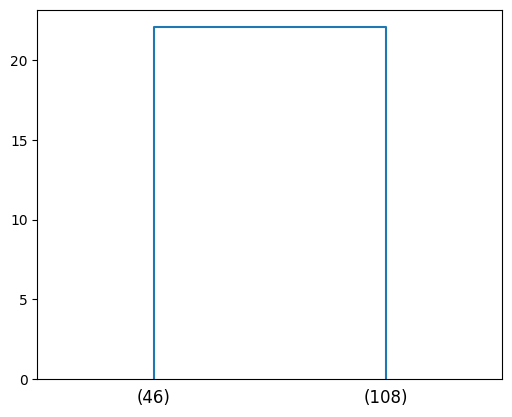

(array([1, 2], dtype=int32), array([ 46, 108], dtype=int64))

In [31]:
# y_target = 5
y_target = 5
dm_squareform = squareform(dist_matrix)
dm_sec = dm_squareform[y==y_target][:,y==y_target]
dm_sec = squareform(dm_sec)
y_sec = hc_fcluster(dm_sec, method='single', n_cls=2, figsize=(6, 4.8))
y_sec = filterOutlier(y_sec,threshold=10)
np.unique(y_sec,return_counts=True)

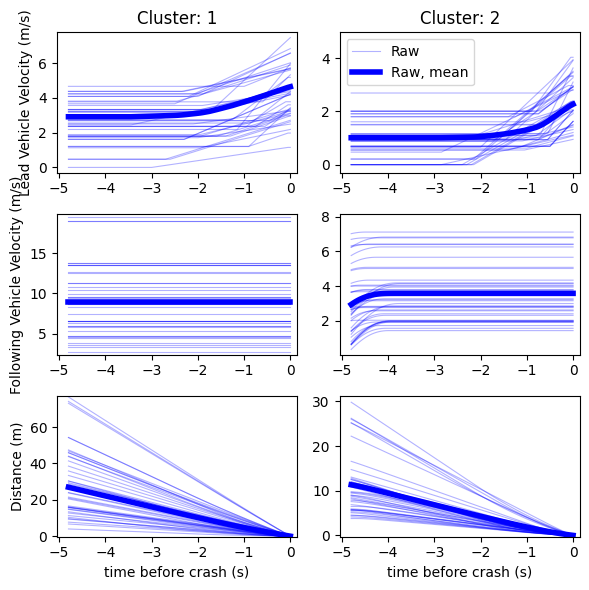

In [32]:
y_sec = filterOutlier(y_sec,threshold=5)
clsInspection(
    X[y==y_target],
    y_sec,
    Weight[y==y_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

Second Clustering y=6

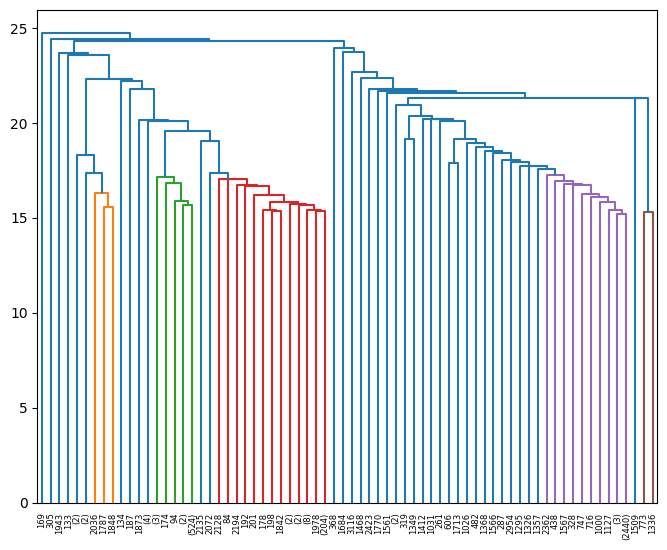

(array([ 0,  9, 18, 38], dtype=int32),
 array([  87,  524,  204, 2440], dtype=int64))

In [33]:
y_target = 6
dm_squareform = squareform(dist_matrix)
dm_sec = dm_squareform[y==y_target][:,y==y_target]
dm_sec = squareform(dm_sec)
# y_sec = hc_fcluster(dm_sec, method='single', n_cls=164, figsize=(8, 6.4))
y_sec = hc_fcluster(dm_sec, method='single', n_cls=70, figsize=(8, 6.4))
y_sec = filterOutlier(y_sec,threshold=10)
np.unique(y_sec,return_counts=True)

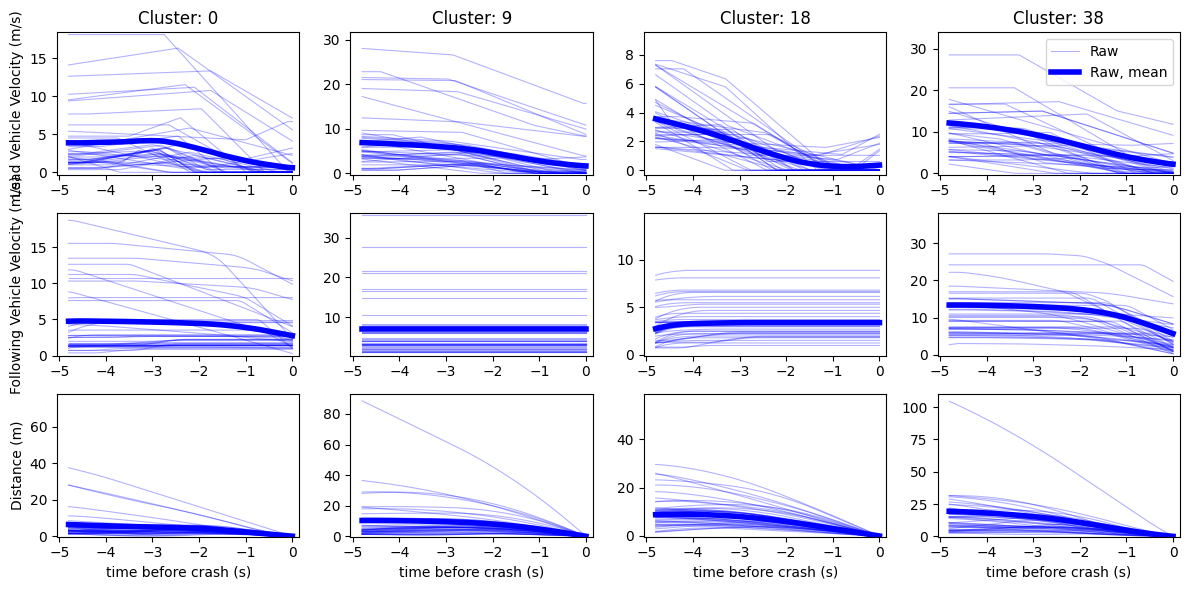

In [34]:
y_sec = filterOutlier(y_sec,threshold=5)
clsInspection(
    X[y==y_target],
    y_sec,
    Weight[y==y_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

Second Clustering y=6.9

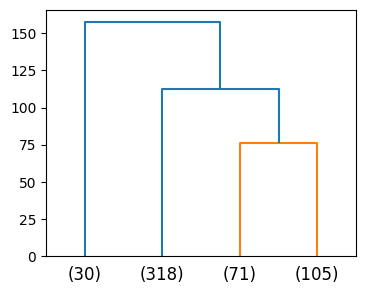

In [35]:
y_target = 6
y_sec_target = 9
dm_squareform = squareform(dist_matrix)
dm_sec_sec = dm_squareform[y==y_target][:,y==y_target][y_sec==y_sec_target][:,y_sec==y_sec_target]
dm_sec_sec = squareform(dm_sec_sec)
y_sec_sec = hc_fcluster(dm_sec_sec, method='complete', n_cls=4, figsize=(4, 3.2))

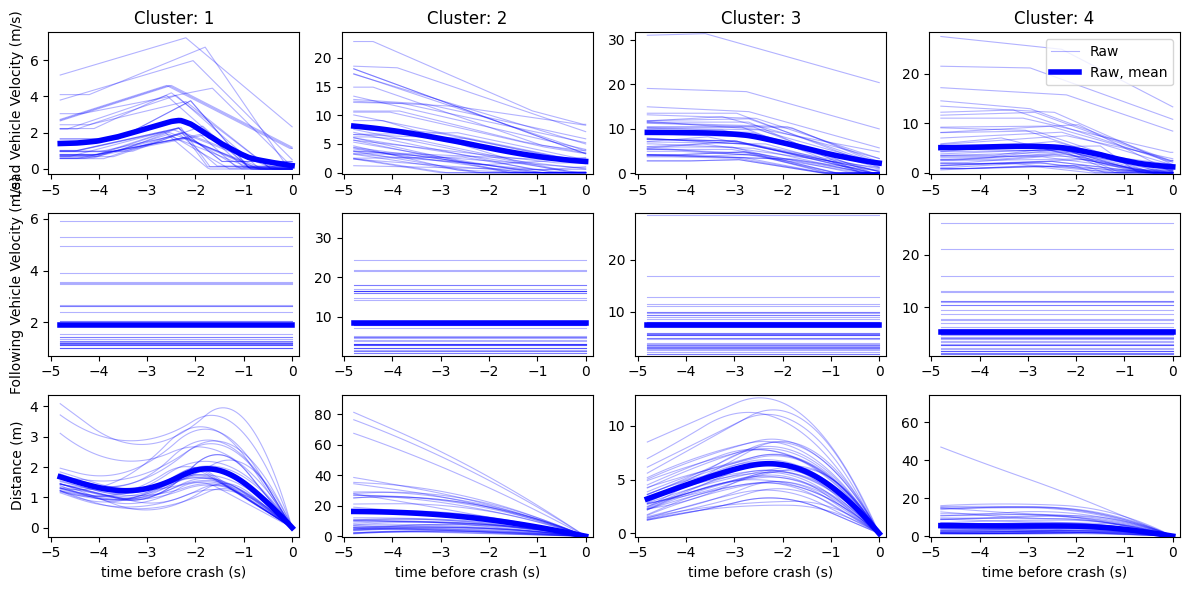

In [36]:
# y_sec = filterOutlier(y_sec,threshold=5)
clsInspection(
    X[y==y_target][y_sec==y_sec_target],
    y_sec_sec,
    Weight[y==y_target][y_sec==y_sec_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

Second Clustering y=6.18

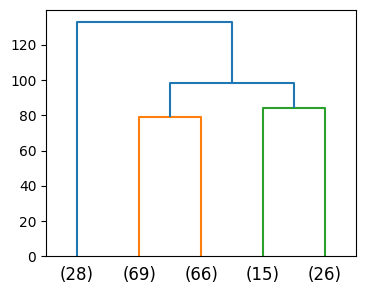

In [37]:
y_target = 6
y_sec_target = 18
dm_squareform = squareform(dist_matrix)
dm_sec_sec = dm_squareform[y==y_target][:,y==y_target][y_sec==y_sec_target][:,y_sec==y_sec_target]
dm_sec_sec = squareform(dm_sec_sec)
y_sec_sec = hc_fcluster(dm_sec_sec, method='complete', n_cls=5, figsize=(4, 3.2))

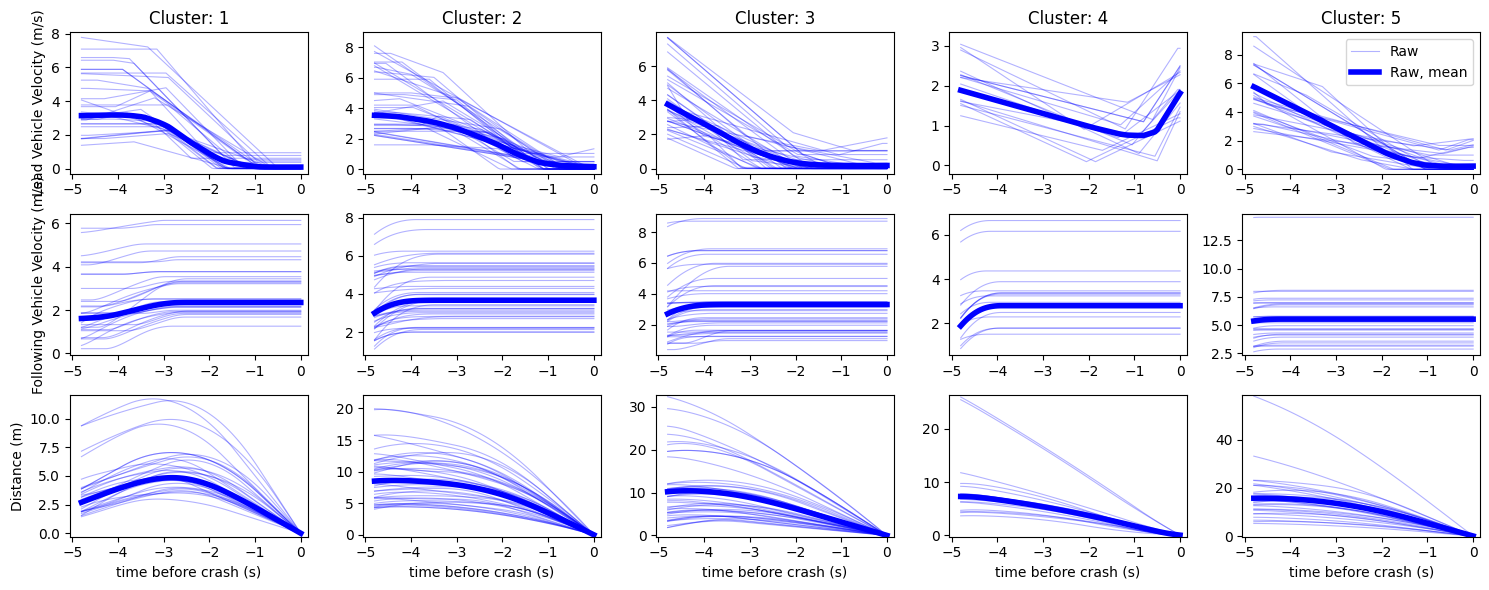

In [38]:
# y_sec = filterOutlier(y_sec,threshold=5)
clsInspection(
    X[y==y_target][y_sec==y_sec_target],
    y_sec_sec,
    Weight[y==y_target][y_sec==y_sec_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

Second Clustering y=6.38

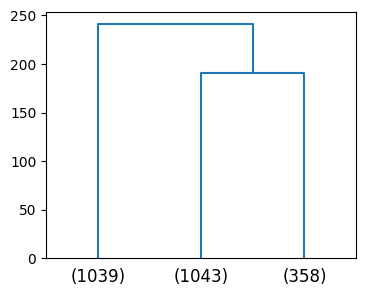

In [39]:
y_target = 6
y_sec_target = 38
dm_squareform = squareform(dist_matrix)
dm_sec_sec = dm_squareform[y==y_target][:,y==y_target][y_sec==y_sec_target][:,y_sec==y_sec_target]
dm_sec_sec = squareform(dm_sec_sec)
y_sec_sec = hc_fcluster(dm_sec_sec, method='complete', n_cls=3, figsize=(4, 3.2))
# y_sec_sec = hc_fcluster(dm_sec_sec, method='single', n_cls=1000, figsize=(10, 8))
# y_sec_sec = filterOutlier(y_sec_sec,threshold=10)
# np.unique(y_sec_sec,return_counts=True)

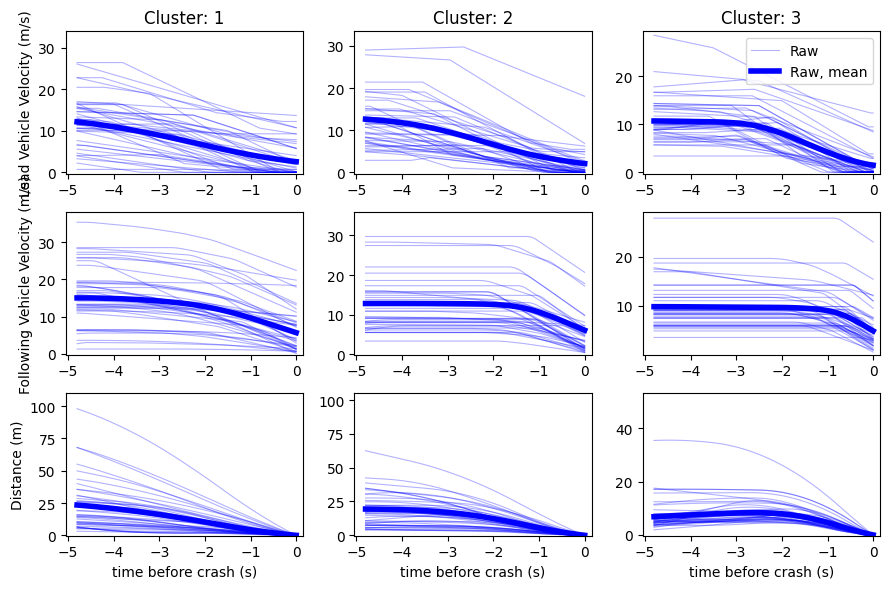

In [40]:
# y_sec = filterOutlier(y_sec,threshold=5)
clsInspection(
    X[y==y_target][y_sec==y_sec_target],
    y_sec_sec,
    Weight[y==y_target][y_sec==y_sec_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)